In [3]:
from glob import glob
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../data/extracted-blots.csv")

In [5]:
df["ar"] = df["width"] / df["height"]
blot_meta = df.copy()

- `square`: 0.75 ≤ AR ≤ 1.8
- `tall`: AR < 0.75
- `wide`: 1.8 < AR < 4
- `super_wide`: AR ≥ 4

In [6]:
square_blots = blot_meta.drop(blot_meta[(blot_meta.ar <= 0.75) | (blot_meta.ar >= 1.8)].index)
tall_blots = blot_meta.drop(blot_meta[(blot_meta.ar > 0.75) ].index)
wide_blots = blot_meta.drop(blot_meta[(blot_meta.ar < 1.8)  | (blot_meta.ar > 4)].index)
super_wide_blots = blot_meta.drop(blot_meta[(blot_meta.ar <= 4) ].index)

blot_meta.loc[square_blots.index, 'blot_type'] = 'square'
blot_meta.loc[tall_blots.index, 'blot_type'] = 'tall'
blot_meta.loc[wide_blots.index, 'blot_type'] = 'wide'
blot_meta.loc[super_wide_blots.index, 'blot_type'] = 'super_wide'

<Axes: xlabel='blot_type'>

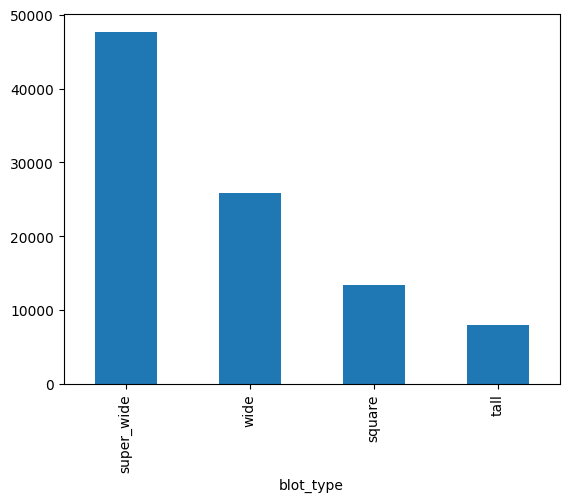

In [7]:
# plot number of blots per type
blot_meta.blot_type.value_counts().plot(kind='bar')

<Axes: >

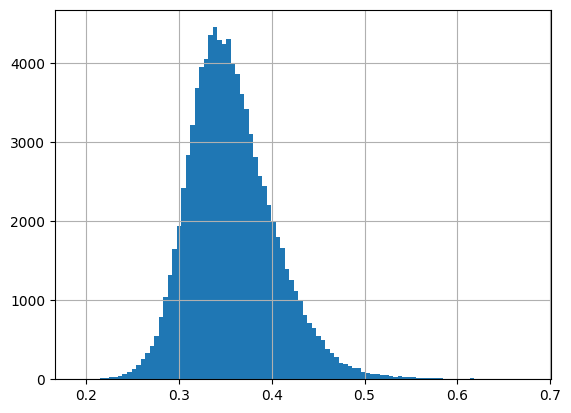

In [8]:
# plot histogram of maniqa-pipal
blot_meta['maniqa-pipal'].hist(bins=100)

<Axes: >

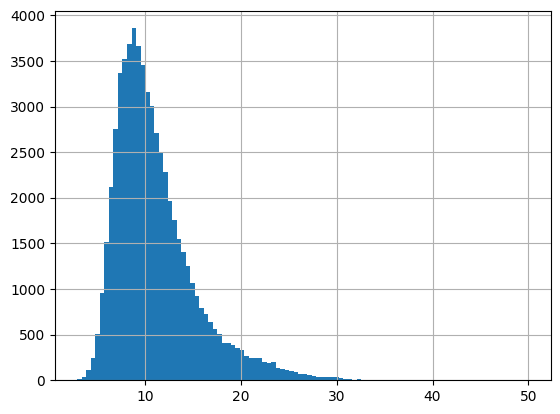

In [9]:
blot_meta[blot_meta['niqe'] <50]['niqe'].hist(bins=100)

<Axes: >

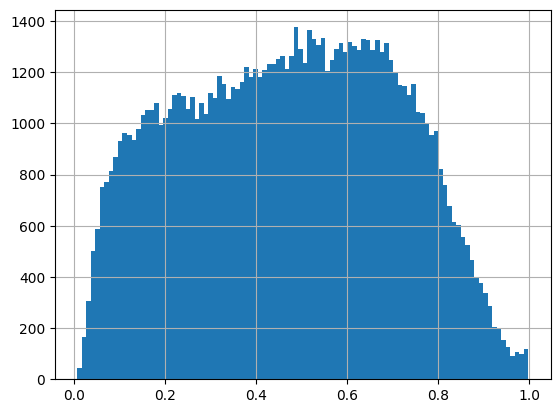

In [12]:
blot_meta[blot_meta['pixelation'] <1]['pixelation'].hist(bins=100)

<Axes: >

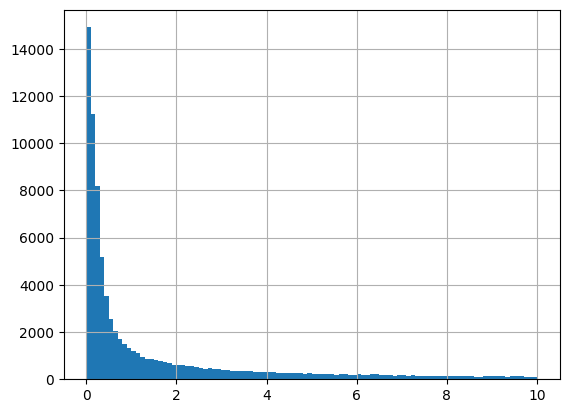

In [16]:
blot_meta[blot_meta['compression'] <10]['compression'].hist(bins=100)

Initial 94942
after text 90041
after maniqa-pipal 29906
after compression 19852
after niqe 16715


<Axes: xlabel='blot_type'>

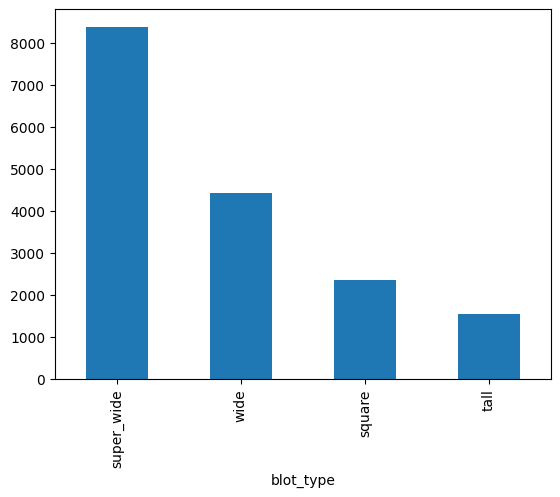

In [17]:
# Removes aberrations
selected_data = blot_meta.copy()
print("Initial", selected_data.shape[0])
selected_data = selected_data[selected_data['has_text'] <= 0.3]
print("after text", selected_data.shape[0])

selected_data = selected_data[selected_data['maniqa-pipal'] >= 0.37]
print("after maniqa-pipal", selected_data.shape[0])
selected_data = selected_data[selected_data['compression'] <= 1]
print("after compression", selected_data.shape[0])
# selected_data = selected_data[selected_data['pixelation'] <= 0.7]
# print("after pixelation", selected_data.shape[0])
selected_data['niqe'] = selected_data['niqe'].fillna(0)
selected_data = selected_data[selected_data['niqe'] <= 10.41]
print("after niqe", selected_data.shape[0])

selected_data.blot_type.value_counts().plot(kind='bar')

In [18]:
# split data in two folds
articles = selected_data['article_id'].unique()
articles = {article: selected_data[selected_data['article_id'] == article]["image_path"].tolist() for article in articles}
# sort articles by number of images
articles = {k: v for k, v in sorted(articles.items(), key=lambda item: len(item[1]), reverse=True)}

fold1 = []
fold2 = []

for article, images in articles.items():
    if len(fold1) <= len(fold2):
        fold1 += images
    else:
        fold2 += images

In [19]:
fold1 = selected_data[selected_data['image_path'].isin(fold1)]
fold2 = selected_data[selected_data['image_path'].isin(fold2)]

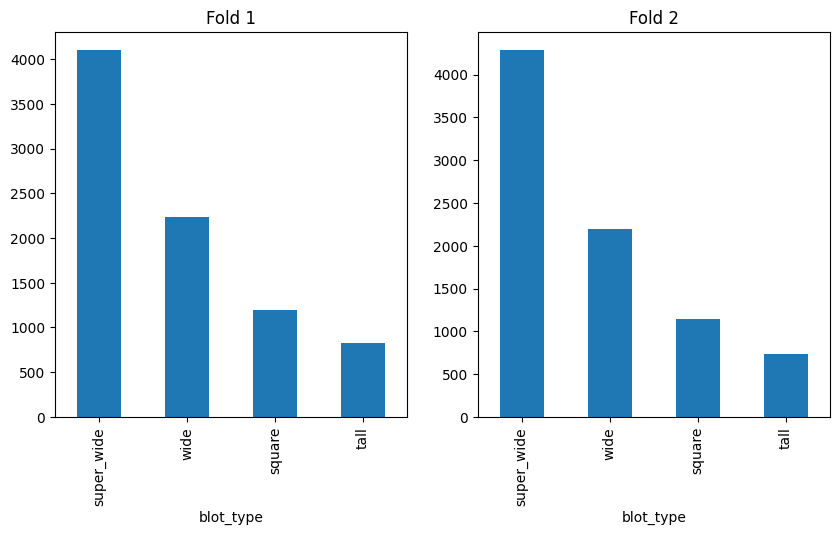

In [21]:
# plot distribution of each fold
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fold1.blot_type.value_counts().plot(kind='bar', ax=ax[0], title="Fold 1")
fold2.blot_type.value_counts().plot(kind='bar', ax=ax[1], title="Fold 2")       
plt.show()